## Evaluating Robust Models

The goal of this notebook is to show how to compare several methods across several datasets.This will also serve as inroduction to two important `scikit-clean` functions: `load_data` and `compare`. 

We'll (roughly) implement the core idea of 3 existing papers on robust classification in the presence of label noise, and see how they compare on our 4 datasets readily available in `scikit-clean`. Those papers are:

1. Forest-type Regression with General Losses and Robust Forest - ICML'17 (`RobustForest`  below in `MODELS` dictionary)
2. An Ensemble Generation Method Based on Instance Hardness- IJCNN'18 (`EGIH`)
3. Classification with label noise- a Markov chain sampling framework - ECML-PKDD'18 (`MCS`)

In [1]:
import os

import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, make_scorer

from skclean.detectors import KDN, InstanceHardness, MCS
from skclean.handlers import WeightedBagging, SampleWeight, Filter
from skclean.models import RobustForest
from skclean.pipeline import Pipeline, make_pipeline
from skclean.utils import load_data, compare

import seaborn as sns

We'll use 4 datasets here, all come preloaded with `scikit-clean`. If you want to load new datasets through this function, put the csv-formatted dataset file in `datasets` folder (use `os.path.dirname(skclean.datasets.__file__)` to get it's location). Make sure labels are at the last column, and features are all real numbers. Check source code of `load_data` for more details.

In [2]:
DATASETS = ['iris', 'breast_cancer', 'optdigits', 'spambase']
SEED = 42   # For reproducibility
N_JOBS = 8  # No of cpu cores to use in parallel
CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED+1) 
SCORING = 'accuracy'

In [3]:
MODELS = {
    'RobustForest': RobustForest(n_estimators=100),
    'EGIH':make_pipeline(KDN(), WeightedBagging()),
    'MCS': make_pipeline(MCS(), SampleWeight(LogisticRegression()))
}

We'll create 30% uniform label noise for all our datasets using `UniformNoise`. Note that we're treating noise simulation as data transformation step and attaching it before our models in a pipeline. In this way, noise will only impact training set, and testing will be performed on clean labels.

In [4]:
from skclean.simulate_noise import UniformNoise

N_MODELS = {}
for name, clf in MODELS.items():
    N_MODELS[name] = make_pipeline(UniformNoise(.3), clf)

`scikit-clean` models are compatible with `scikit-learn` API. So for evaluation, we'll use `cross_val_score` function of scikit-learn- this will create multiple train/test according to the `CV` variable we defined at the beginning, and compute performance. It also allows easily parallelizing the code using `n_jobs`.

In [5]:
from time import perf_counter  # Wall time
from sklearn.model_selection import cross_val_score

for data_name in DATASETS:
    X,y = load_data(data_name, stats=True) 
    
    for clf_name, clf in N_MODELS.items():
        start_at = perf_counter()
        r = cross_val_score(clf, X, y, cv=CV, n_jobs=N_JOBS, scoring=SCORING).mean()
        print(f"{data_name}, {clf_name}: {r:.4f} in {perf_counter()-start_at:.2f} secs")
    print()

iris, (150, 4), 3, 1.000

iris, RobustForest: 0.8067 in 0.94 secs
iris, EGIH: 0.9133 in 0.73 secs
iris, MCS: 0.7067 in 0.11 secs

breast_cancer, (569, 30), 2, 0.594

breast_cancer, RobustForest: 0.8664 in 0.22 secs
breast_cancer, EGIH: 0.8981 in 0.82 secs
breast_cancer, MCS: 0.9367 in 0.11 secs

optdigits, (5620, 64), 10, 0.969

optdigits, RobustForest: 0.9402 in 1.48 secs
optdigits, EGIH: 0.9649 in 8.03 secs
optdigits, MCS: 0.9584 in 6.36 secs

spambase, (4601, 57), 2, 0.650

spambase, RobustForest: 0.7857 in 1.12 secs
spambase, EGIH: 0.8581 in 7.18 secs
spambase, MCS: 0.8303 in 0.45 secs



The `compare` function does basically the same thing the above cell does. Plus, it stores the results in a CSV format, with datasets in rows and algorithms in columns. And it can also automatically resume after interruption.

In [6]:
%%time
result_path = "noisy.csv"

dfn = compare(N_MODELS, DATASETS, cv=CV, df_path=result_path, random_state=SEED,
             scoring=SCORING,n_jobs=N_JOBS, verbose=False)
dfn

Wall time: 24.5 s


,RobustForest,EGIH,MCS
iris,0.806667,0.866667,0.726667
breast_cancer,0.84875,0.878808,0.938488
optdigits,0.941459,0.958541,0.959253
spambase,0.776793,0.859382,0.817


Let's compare above values with ones computed with clean labels:

In [7]:
dfc = compare(MODELS, DATASETS, cv=CV, df_path=None, random_state=SEED,
             scoring=SCORING,n_jobs=N_JOBS, verbose=False)
dfc

,RobustForest,EGIH,MCS
iris,0.953333,0.946667,0.806667
breast_cancer,0.957833,0.940273,0.950846
optdigits,0.978648,0.963701,0.965125
spambase,0.949577,0.938707,0.850471


In [8]:
dfc = dfc.assign(label='clean')
dfn = dfn.assign(label='noisy')
df = pd.concat([dfc,dfn]).melt(id_vars='label')
df.rename(columns={'variable':'classifier','value':SCORING},inplace=True)

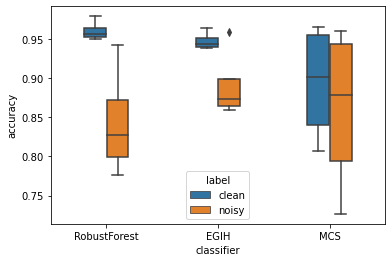

In [9]:
sns.boxplot(data=df,hue='label',x='classifier',y=SCORING,width=.4);

In [10]:
os.remove(result_path)

Note: This is a simple example, not a replication study, and shouldn't be taken as such.